In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

path = "/content/drive/My Drive/team_a/data/xy_data"

os.chdir(path)
os.listdir(path)

Mounted at /content/drive


['user_info_l.csv',
 'user_info_s.csv',
 'mobile.csv',
 'application.csv',
 'internal_score.csv',
 'pty3rd.csv',
 'inquiry.csv',
 'account.csv',
 'readme.txt',
 'internal data_clean.csv',
 'account_cleaned.csv',
 'pty3rd_cleaned.csv',
 'application_cleaned.csv',
 'mobile_cleaned.csv',
 'inquiry_cleaned.csv',
 'zero_features_drop (2).gsheet',
 'basic_universe.csv',
 'continuous.csv',
 'categorical.csv',
 'zero_features_drop (1).gsheet',
 'application (1).gsheet',
 'application.gsheet',
 'application_oot.csv',
 'inquiry_oot.csv',
 'user_info_l_oot.csv',
 'mobile_oot.csv',
 'internal_score_oot.csv',
 'pty3rd_oot.csv',
 'account_oot.csv',
 'zero_features_drop.csv',
 'zero_features_drop.gsheet',
 'var_description.csv',
 'lgbm_importances-01.png',
 'merge_cleaned.csv',
 'Model_based_Feature_Selection_Lasso.csv',
 'Model_based_Feature_Selection_LGBM.csv',
 'Model_based_Feature_Selection_Lasso_50percent.csv',
 'Model_based_Feature_Selection_Lasso_Basic_Universe.csv',
 'data_bin.csv',
 'data_bi

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.preprocessing import MinMaxScaler

# filter warnings
import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
basic=pd.read_csv('cleaned_v5_xy.csv')

In [4]:
print(basic.isnull().values.any())


False


In [5]:
#look for datatype object
print(basic.select_dtypes(include='object').columns)

Index([], dtype='object')


In [6]:
basic.shape

(99072, 345)

In [7]:
y = basic['label']
X = basic.drop(columns=['applied_id','label'])

## Models on Basic Universe



### Define functions

#### Basic Models

In [8]:
def tuning(model, parameters):
  roc=[]
  tprs = []
  pr=[]
  prs = []
  mean_fpr = np.linspace(0,1,100)
  mean_precision = np.linspace(0,1,100)
  i=1
  skf=StratifiedKFold(n_splits=5,random_state=42)
  skf.get_n_splits(X,y)

  for train_index,test_index in skf.split(X,y):
    print('{} of KFold {}'.format(i,skf.n_splits))
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    y_train,y_test=y.iloc[train_index],y.iloc[test_index]
  
    #model
    clf = GridSearchCV(model,scoring='roc_auc', param_grid=parameters, cv=2)
    clf.fit(X_train, y_train)
    print("best parameters: {}".format(clf.best_params_))
    clf_proba=clf.predict_proba(X_test)[:,1]

    #roc_auc score
    roc_score=roc_auc_score(y_test,clf_proba)

    #pr curve and pr auc
    clf_precision, clf_recall, t = precision_recall_curve(y_test,clf_proba)
    prs.append(np.interp(mean_precision,clf_precision,clf_recall))

    #pr_auc score
    pr_score=auc(clf_recall,clf_precision)

   
    #roc curve
    clf_fpr, clf_tpr, t = roc_curve(y_test, clf_proba)
    tprs.append(np.interp(mean_fpr, clf_fpr, clf_tpr))


    print('ROC AUC score:',roc_score)
    print('PR AUC score:',pr_score)
    roc.append(roc_score)
    pr.append(pr_score)
    i+=1


  print('Mean ROC AUC Score',round(np.mean(roc),3),'\nMean PR AUC Score', round(np.mean(pr),3))
  # calculate scores
  ns_probs = [0 for _ in range(len(y_test))]
  ns_auc = roc_auc_score(y_test, ns_probs)

  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  mean_fpr=np.linspace(0,1,100)
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--')
  plt.plot(mean_fpr, mean_tpr, marker='.')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the plot
  plt.show()
  # summarize scores
  print('ROC AUC=%.3f' % (mean_auc))

  # precision-recall curve 
 

  mean_precision = np.linspace(0,1,100)
  mean_recall = np.mean(prs, axis=0)
  mean_auc = auc(mean_precision,mean_recall)

  # plot the precision-recall curves
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
  plt.plot(mean_recall, mean_precision, marker='.')
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')

  # show the plot
  plt.show()
  # summarize scores
  print('PR AUC=%.3f' % (mean_auc))



#### Oversampling Models

In [10]:
def tuning_oversampling(model, parameters,over_method):
  roc=[]
  tprs = []
  pr=[]
  prs = []
  mean_fpr = np.linspace(0,1,100)
  mean_precision = np.linspace(0,1,100)
  i=1
  skf=StratifiedKFold(n_splits=5,random_state=42)
  skf.get_n_splits(X,y)

  for train_index,test_index in skf.split(X,y):
    print('{} of KFold {}'.format(i,skf.n_splits))
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    y_train,y_test=y.iloc[train_index],y.iloc[test_index]
    
    over = over_method(sampling_strategy=0.5,random_state=42)
    X_train_over, y_train_over = over.fit_resample(X_train, y_train)
    X_train_over=pd.DataFrame(X_train_over)
    y_train_over=pd.DataFrame(y_train_over)

    #model
    clf = GridSearchCV(model,scoring='roc_auc', param_grid=parameters, cv=2)
    clf.fit(X_train, y_train)
    print("best parameters: {}".format(clf.best_params_))
    clf_proba=clf.predict_proba(X_test)[:,1]

    #roc_auc score
    roc_score=roc_auc_score(y_test,clf_proba)

    #pr curve and pr auc
    clf_precision, clf_recall, t = precision_recall_curve(y_test,clf_proba)
    prs.append(np.interp(mean_precision,clf_precision,clf_recall))

    #pr_auc score
    pr_score=auc(clf_recall,clf_precision)

   
    #roc curve
    clf_fpr, clf_tpr, t = roc_curve(y_test, clf_proba)
    tprs.append(np.interp(mean_fpr, clf_fpr, clf_tpr))


    print('ROC AUC score:',roc_score)
    print('PR AUC score:',pr_score)
    roc.append(roc_score)
    pr.append(pr_score)
    i+=1


  print('Mean ROC AUC Score',round(np.mean(roc),3),'\nMean PR AUC Score', round(np.mean(pr),3))
  # calculate scores
  ns_probs = [0 for _ in range(len(y_test))]
  ns_auc = roc_auc_score(y_test, ns_probs)

  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  mean_fpr=np.linspace(0,1,100)
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--')
  plt.plot(mean_fpr, mean_tpr, marker='.')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

  # show the plot
  plt.show()
  # summarize scores
  print('ROC AUC=%.3f' % (mean_auc))

  # precision-recall curve 
 

  mean_precision = np.linspace(0,1,100)
  mean_recall = np.mean(prs, axis=0)
  mean_auc = auc(mean_precision,mean_recall)

  # plot the precision-recall curves
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
  plt.plot(mean_recall, mean_precision, marker='.')
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  # show the plot
  plt.show()
  # summarize scores
  print('PR AUC=%.3f' % (mean_auc))

#### Undersampling Models

In [11]:
def tuning_undersampling(model, parameters,under_method):
  roc=[]
  tprs = []
  pr=[]
  prs = []
  mean_fpr = np.linspace(0,1,100)
  mean_precision = np.linspace(0,1,100)
  i=1
  skf=StratifiedKFold(n_splits=5,random_state=42)
  skf.get_n_splits(X,y)

  for train_index,test_index in skf.split(X,y):
    print('{} of KFold {}'.format(i,skf.n_splits))
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    y_train,y_test=y.iloc[train_index],y.iloc[test_index]
    
    under = under_method(sampling_strategy=0.5,random_state=42)
    X_train_under, y_train_under = under.fit_resample(X_train, y_train)
    X_train_under=pd.DataFrame(X_train_under)
    y_train_under=pd.DataFrame(y_train_under)

    #model
    clf = GridSearchCV(model,scoring='roc_auc', param_grid=parameters, cv=2)
    clf.fit(X_train, y_train)
    print("best parameters: {}".format(clf.best_params_))
    clf_proba=clf.predict_proba(X_test)[:,1]

    #roc_auc score
    roc_score=roc_auc_score(y_test,clf_proba)

    #pr curve and pr auc
    clf_precision, clf_recall, t = precision_recall_curve(y_test,clf_proba)
    prs.append(np.interp(mean_precision,clf_precision,clf_recall))

    #pr_auc score
    pr_score=auc(clf_recall,clf_precision)

   
    #roc curve
    clf_fpr, clf_tpr, t = roc_curve(y_test, clf_proba)
    tprs.append(np.interp(mean_fpr, clf_fpr, clf_tpr))


    print('ROC AUC score:',roc_score)
    print('PR AUC score:',pr_score)
    roc.append(roc_score)
    pr.append(pr_score)
    i+=1


  print('Mean ROC AUC Score',round(np.mean(roc),3),'\nMean PR AUC Score', round(np.mean(pr),3))
  # calculate scores
  ns_probs = [0 for _ in range(len(y_test))]
  ns_auc = roc_auc_score(y_test, ns_probs)

  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  mean_fpr=np.linspace(0,1,100)
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--')
  plt.plot(mean_fpr, mean_tpr, marker='.')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')

  # show the plot
  plt.show()
  # summarize scores
  print('ROC AUC=%.3f' % (mean_auc))

  # precision-recall curve 

  mean_precision = np.linspace(0,1,100)
  mean_recall = np.mean(prs, axis=0)
  mean_auc = auc(mean_precision,mean_recall)

  # plot the precision-recall curves
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
  plt.plot(mean_recall, mean_precision, marker='.')
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')

  # show the plot
  plt.show()
  # summarize scores
  print('PR AUC=%.3f' % (mean_auc))

#### Voting/Stacking

In [12]:
def no_tuning(clf):
  roc=[]
  tprs = []
  pr=[]
  prs = []
  mean_fpr = np.linspace(0,1,100)
  mean_precision = np.linspace(0,1,100)
  i=1
  skf=StratifiedKFold(n_splits=5,random_state=42)
  skf.get_n_splits(X,y)

  for train_index,test_index in skf.split(X,y):
    print('{} of KFold {}'.format(i,skf.n_splits))
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    y_train,y_test=y.iloc[train_index],y.iloc[test_index]
  
    #model
    clf.fit(X_train, y_train)
    clf_proba=clf.predict_proba(X_test)[:,1]

    #roc_auc score
    roc_score=roc_auc_score(y_test,clf_proba)

    #pr curve and pr auc
    clf_precision, clf_recall, t = precision_recall_curve(y_test,clf_proba)
    prs.append(np.interp(mean_precision,clf_precision,clf_recall))

    #pr_auc score
    pr_score=auc(clf_recall,clf_precision)

   
    #roc curve
    clf_fpr, clf_tpr, t = roc_curve(y_test, clf_proba)
    tprs.append(np.interp(mean_fpr, clf_fpr, clf_tpr))


    print('ROC AUC score:',roc_score)
    print('PR AUC score:',pr_score)
    roc.append(roc_score)
    pr.append(pr_score)
    i+=1


  print('Mean ROC AUC Score',round(np.mean(roc),3),'\nMean PR AUC Score', round(np.mean(pr),3))
  # calculate scores
  ns_probs = [0 for _ in range(len(y_test))]
  ns_auc = roc_auc_score(y_test, ns_probs)

  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  mean_fpr=np.linspace(0,1,100)
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--')
  plt.plot(mean_fpr, mean_tpr, marker='.')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the plot
  plt.show()
  # summarize scores
  print('ROC AUC=%.3f' % (mean_auc))

  # precision-recall curve 
  mean_precision = np.linspace(0,1,100)
  mean_recall = np.mean(prs, axis=0)
  mean_auc = auc(mean_precision,mean_recall)

  # plot the precision-recall curves
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
  plt.plot(mean_recall, mean_precision, marker='.')
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')

  # show the plot
  plt.show()
  # summarize scores
  print('PR AUC=%.3f' % (mean_auc))


#### ANN Model

In [13]:
def ANN(clf,a,b):
  roc=[]
  tprs = []
  pr=[]
  prs = []
  mean_fpr = np.linspace(0,1,100)
  mean_precision = np.linspace(0,1,100)
  i=1
  skf=StratifiedKFold(n_splits=5,random_state=42)
  skf.get_n_splits(X,y)

  for train_index,test_index in skf.split(X,y):
    print('{} of KFold {}'.format(i,skf.n_splits))
    X_train,X_test=X.iloc[train_index], X.iloc[test_index]
    y_train,y_test=y.iloc[train_index],y.iloc[test_index]

    #standardize the data
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    #model
    clf.fit(X_train, y_train, epochs=a, batch_size=b)
    clf_proba=clf.predict_proba(X_test)

    #roc_auc score
    roc_score=roc_auc_score(y_test,clf_proba)

    #pr curve and pr auc
    clf_precision, clf_recall, t = precision_recall_curve(y_test,clf_proba)
    prs.append(np.interp(mean_precision,clf_precision,clf_recall))

    #pr_auc score
    pr_score=auc(clf_recall,clf_precision)

   
    #roc curve
    clf_fpr, clf_tpr, t = roc_curve(y_test, clf_proba)
    tprs.append(np.interp(mean_fpr, clf_fpr, clf_tpr))
 

    print('ROC AUC score:',roc_score)
    print('PR AUC score:',pr_score)
    roc.append(roc_score)
    pr.append(pr_score)
    i+=1


  print('Mean ROC AUC Score',round(np.mean(roc),3),'\nMean PR AUC Score', round(np.mean(pr),3))
  # calculate scores
  ns_probs = [0 for _ in range(len(y_test))]
  ns_auc = roc_auc_score(y_test, ns_probs)

  # calculate roc curves
  ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
  mean_fpr=np.linspace(0,1,100)
  mean_tpr = np.mean(tprs, axis=0)
  mean_auc = auc(mean_fpr, mean_tpr)
  # plot the roc curve for the model
  plt.plot(ns_fpr, ns_tpr, linestyle='--')
  plt.plot(mean_fpr, mean_tpr, marker='.')
  # axis labels
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  # show the plot
  plt.show()
  # summarize scores
  print('ROC AUC=%.3f' % (mean_auc))

  # precision-recall curve 
  mean_precision = np.linspace(0,1,100)
  mean_recall = np.mean(prs, axis=0)
  mean_auc = auc(mean_precision,mean_recall)

  # plot the precision-recall curves
  no_skill = len(y[y==1]) / len(y)
  plt.plot([0, 1], [no_skill, no_skill], linestyle='--')
  plt.plot(mean_recall, mean_precision, marker='.')
  # axis labels
  plt.xlabel('Recall')
  plt.ylabel('Precision')

  # show the plot
  plt.show()
  # summarize scores
  print('PR AUC=%.3f' % (mean_auc))


### GBM

1 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 180}
ROC AUC score: 0.7013858366663994
PR AUC score: 0.2713989291478085
2 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 180}
ROC AUC score: 0.6980908260252232
PR AUC score: 0.2626888722833455
3 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 180}
ROC AUC score: 0.6887095999770909
PR AUC score: 0.2603555302776407
4 of KFold 5
best parameters: {'max_depth': 4, 'n_estimators': 140}
ROC AUC score: 0.6947859737680001
PR AUC score: 0.2709724515914591
5 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 160}
ROC AUC score: 0.6961862976190774
PR AUC score: 0.2627535651144119
Mean ROC AUC Score 0.696 
Mean PR AUC Score 0.266


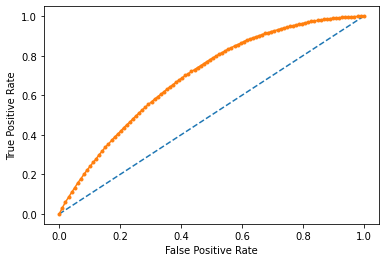

ROC AUC=0.696


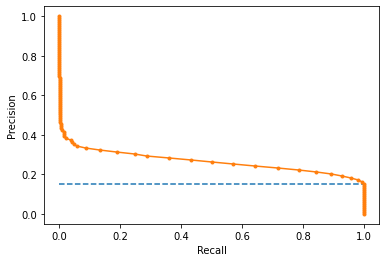

PR AUC=0.266


In [ ]:
parameters= {'n_estimators': range(20,200,20),'max_depth':[2,3,4]}
model=XGBClassifier()
tuning(model,parameters)

### Random Forest

1 of KFold 5
best parameters: {'max_depth': 9, 'n_estimators': 80}
ROC AUC score: 0.6909228484186674
PR AUC score: 0.2631220672338851
2 of KFold 5
best parameters: {'max_depth': 9, 'n_estimators': 80}
ROC AUC score: 0.687496976048898
PR AUC score: 0.25437547413561296
3 of KFold 5
best parameters: {'max_depth': 9, 'n_estimators': 80}
ROC AUC score: 0.6799578712064105
PR AUC score: 0.2534333490809696
4 of KFold 5
best parameters: {'max_depth': 8, 'n_estimators': 80}
ROC AUC score: 0.6831017903595255
PR AUC score: 0.25829849908481345
5 of KFold 5
best parameters: {'max_depth': 8, 'n_estimators': 80}
ROC AUC score: 0.6878406341316105
PR AUC score: 0.25322961399421207
Mean ROC AUC Score 0.686 
Mean PR AUC Score 0.256


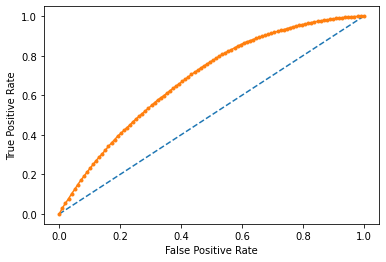

ROC AUC=0.686


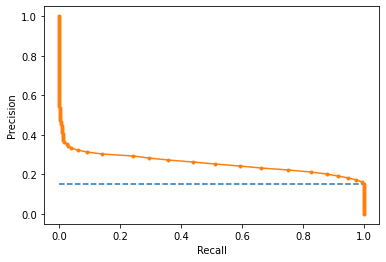

PR AUC=0.257


In [ ]:
parameters= {'n_estimators': range(20,100,20),'max_depth':[8,9,10]}
model=RandomForestClassifier()
tuning(model,parameters)

### GBM with Oversampling

1 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 180}
ROC AUC score: 0.700475040209742
PR AUC score: 0.26837749769347663
2 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 180}
ROC AUC score: 0.6968170477875874
PR AUC score: 0.2629915781239054
3 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 180}
ROC AUC score: 0.687880713927558
PR AUC score: 0.25997220973122553
4 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 180}
ROC AUC score: 0.693855857372076
PR AUC score: 0.26807998516937726
5 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 180}
ROC AUC score: 0.6959992699410565
PR AUC score: 0.2625859104980108
Mean ROC AUC Score 0.695 
Mean PR AUC Score 0.264


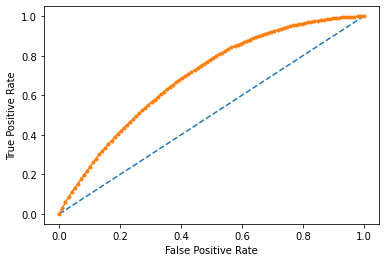

ROC AUC=0.695


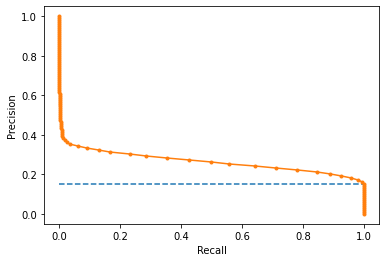

PR AUC=0.265


In [ ]:
parameters= {'n_estimators': range(100,200,20),'max_depth':[2,3,4]}
model=GradientBoostingClassifier()
tuning_oversampling(model,parameters,SMOTE)

### GBM with Undersampling

1 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 180}
ROC AUC score: 0.700504105370819
PR AUC score: 0.2682077236134991
2 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 180}
ROC AUC score: 0.6968382448040495
PR AUC score: 0.26297994271361946
3 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 180}
ROC AUC score: 0.6880943213485928
PR AUC score: 0.2607761944793111
4 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 180}
ROC AUC score: 0.6938114915287474
PR AUC score: 0.2675100590281677
5 of KFold 5
best parameters: {'max_depth': 3, 'n_estimators': 180}
ROC AUC score: 0.6958375480231864
PR AUC score: 0.26207152021934116
Mean ROC AUC Score 0.695 
Mean PR AUC Score 0.264


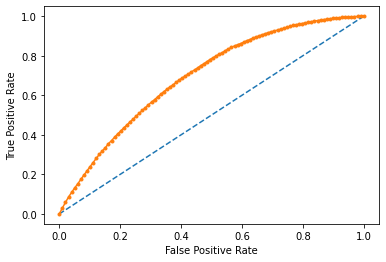

ROC AUC=0.695


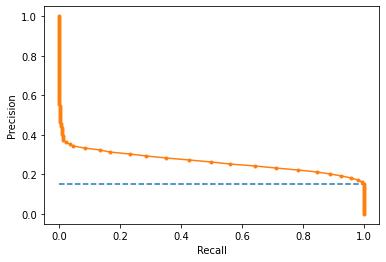

PR AUC=0.265


In [ ]:
parameters= {'n_estimators': range(100,200,20),'max_depth':[2,3,4]}
model=GradientBoostingClassifier()
tuning_undersampling(model,parameters,RandomUnderSampler)

### Random Forest with Oversampling

1 of KFold 5
best parameters: {'max_depth': 11, 'n_estimators': 180}
ROC AUC score: 0.6935300520847686
PR AUC score: 0.26388076470790023
2 of KFold 5
best parameters: {'max_depth': 10, 'n_estimators': 120}
ROC AUC score: 0.6881366053175818
PR AUC score: 0.25426397522919697
3 of KFold 5
best parameters: {'max_depth': 11, 'n_estimators': 160}
ROC AUC score: 0.6802889597729642
PR AUC score: 0.25260569991331355
4 of KFold 5
best parameters: {'max_depth': 10, 'n_estimators': 180}
ROC AUC score: 0.6855554603584729
PR AUC score: 0.2624105425429659
5 of KFold 5
best parameters: {'max_depth': 10, 'n_estimators': 160}
ROC AUC score: 0.6891163674954766
PR AUC score: 0.256680661211629
Mean ROC AUC Score 0.687 
Mean PR AUC Score 0.258


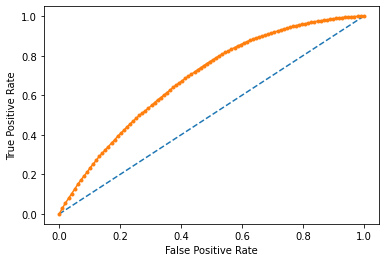

ROC AUC=0.687


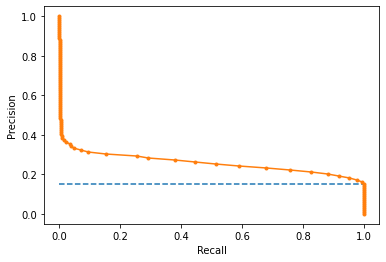

PR AUC=0.258


In [ ]:
parameters= {'n_estimators': range(100,200,20),'max_depth':[10,11]}
model=RandomForestClassifier()
tuning_oversampling(model,parameters,SMOTE)

### Random Forest with Undersampling

1 of KFold 5
best parameters: {'max_depth': 10, 'n_estimators': 180}
ROC AUC score: 0.693112296665222
PR AUC score: 0.2630289145342299
2 of KFold 5
best parameters: {'max_depth': 10, 'n_estimators': 180}
ROC AUC score: 0.6884166192751223
PR AUC score: 0.256733757712829
3 of KFold 5
best parameters: {'max_depth': 10, 'n_estimators': 180}
ROC AUC score: 0.6804803706563416
PR AUC score: 0.2531821789962032
4 of KFold 5
best parameters: {'max_depth': 10, 'n_estimators': 180}
ROC AUC score: 0.6855592097225495
PR AUC score: 0.26059623299705237
5 of KFold 5
best parameters: {'max_depth': 10, 'n_estimators': 160}
ROC AUC score: 0.6882965293928215
PR AUC score: 0.25388505619636637
Mean ROC AUC Score 0.687 
Mean PR AUC Score 0.257


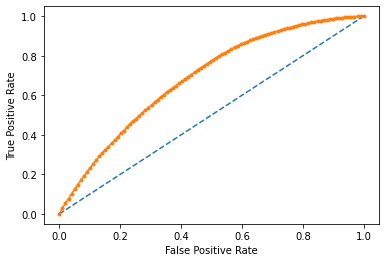

ROC AUC=0.687


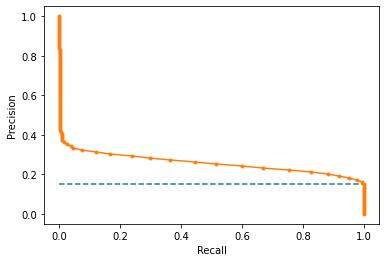

PR AUC=0.258


In [ ]:
parameters= {'n_estimators': range(100,200,20),'max_depth':[10,11]}
model=RandomForestClassifier()
tuning_undersampling(model,parameters,RandomUnderSampler)

### Voting model based on GBM and Random Forest

In [14]:
# Build multiple classification models
gb = GradientBoostingClassifier(n_estimators=180, max_depth=3,random_state=42) #gradient boosting
rf = RandomForestClassifier(n_estimators=80,max_depth=9,random_state=42) # Random Forest

1 of KFold 5
ROC AUC score: 0.6991146928088446
PR AUC score: 0.2684816574558033
2 of KFold 5
ROC AUC score: 0.6947169577854078
PR AUC score: 0.2620579068306011
3 of KFold 5
ROC AUC score: 0.6862341868998187
PR AUC score: 0.26051681198995247
4 of KFold 5
ROC AUC score: 0.6912948459185617
PR AUC score: 0.2675793718528589
5 of KFold 5
ROC AUC score: 0.6950788451128498
PR AUC score: 0.2625085441318208
Mean ROC AUC Score 0.693 
Mean PR AUC Score 0.264


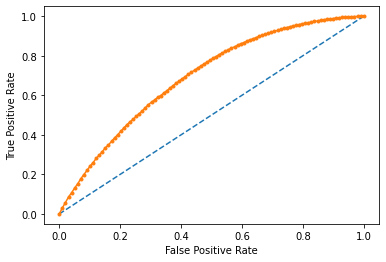

ROC AUC=0.693


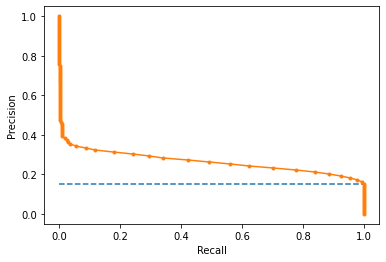

PR AUC=0.265


In [15]:
from sklearn.ensemble import VotingClassifier
clf = VotingClassifier(
    estimators=[('gb', gb), ('rf', rf)],
    voting='soft') #predicts the class label based on the argmax of the sums of the predicted probabilities

no_tuning(clf)

### Stacking model based on GBM and RF

In [16]:
# Build multiple classification models
gb = GradientBoostingClassifier(n_estimators=180, max_depth=3,random_state=42) #gradient boosting
rf = RandomForestClassifier(n_estimators=80,max_depth=9,random_state=42) # Random Forest
ab = AdaBoostClassifier(n_estimators=80, random_state=42) #adaboost

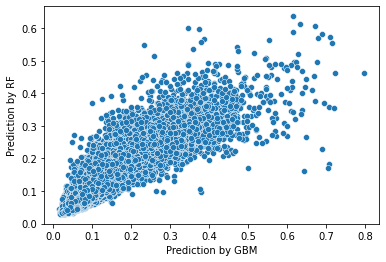

In [19]:
gb.fit(X,y)
rf.fit(X,y)
gb_proba=gb.predict_proba(X)[:,1]
rf_proba=rf.predict_proba(X)[:,1]

fig = sns.scatterplot(x=gb_proba, y=rf_proba)
plt.xlabel("Prediction by GBM")
plt.ylabel("Prediction by RF")
plt.show(fig)

1 of KFold 5
ROC AUC score: 0.7011173117657965
PR AUC score: 0.27165793156614504
2 of KFold 5
ROC AUC score: 0.69599938706762
PR AUC score: 0.2610648423022633
3 of KFold 5
ROC AUC score: 0.6871084251343179
PR AUC score: 0.2563615665833233
4 of KFold 5
ROC AUC score: 0.6919252383459976
PR AUC score: 0.26407113356692224
5 of KFold 5
ROC AUC score: 0.6954590188828548
PR AUC score: 0.2630726962002632
Mean ROC AUC Score 0.694 
Mean PR AUC Score 0.263


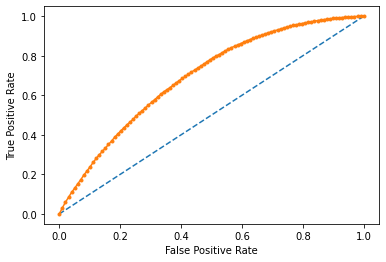

ROC AUC=0.694


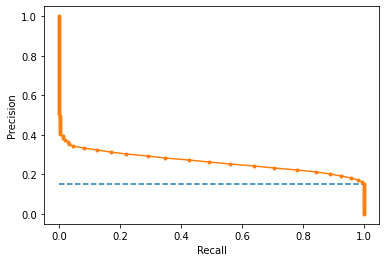

PR AUC=0.264


In [20]:
estimators=[('gb', gb), ('rf', rf)]
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
stack = StackingClassifier(estimators=estimators,final_estimator=GradientBoostingClassifier(random_state=42))
#use a new model to learn how to best combine the predictions from models trained before
no_tuning(stack)

### ANN

In [21]:
X.shape

(99072, 343)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               34400     
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5050      
_________________________________________________________________
dense_2 (Dense)              (None, 30)                1530      
_________________________________________________________________
dense_3 (Dense)              (None, 20)                620       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 6

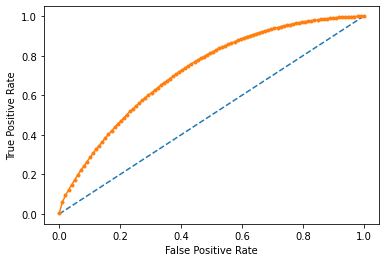

ROC AUC=0.723


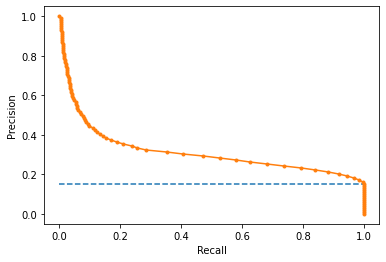

PR AUC=0.315


In [22]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from numpy.random import seed
seed(1)

ann1 = Sequential()
#input layer
ann1.add(Dense(100, activation='relu', input_dim=343))

#1st hidden layer
ann1.add(Dense(50, activation='relu'))

#2nd hidden layer
ann1.add(Dense(30, activation='relu'))

#3rd hidden layer
ann1.add(Dense(20, activation='relu'))

#4th hidden layer
ann1.add(Dense(10, activation='relu'))

#5th hidden layer
ann1.add(Dense(5, activation='relu'))

#output layer
ann1.add(Dense(1, activation='sigmoid'))

ann1.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann1.summary()
ANN(ann1,10,100)  #epochs=10 batch_size=100

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_49 (Dense)             (None, 100)               41500     
_________________________________________________________________
dense_50 (Dense)             (None, 80)                8080      
_________________________________________________________________
dense_51 (Dense)             (None, 30)                2430      
_________________________________________________________________
dense_52 (Dense)             (None, 20)                620       
_________________________________________________________________
dense_53 (Dense)             (None, 10)                210       
_________________________________________________________________
dense_54 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_55 (Dense)             (None, 1)                

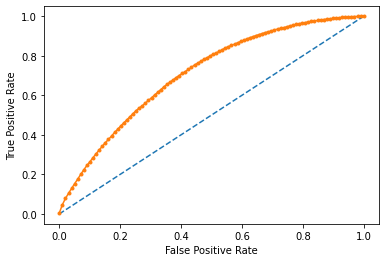

ROC AUC=0.709


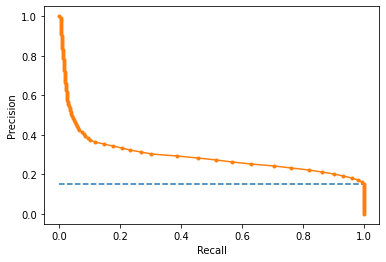

PR AUC=0.294


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from numpy.random import seed
seed(1)

ann2 = Sequential()
#input layer
ann2.add(Dense(100, activation='relu', input_dim=414))
#1st hidden layer
ann2.add(Dense(80, activation='relu'))

#2nd hidden layer
ann2.add(Dense(30, activation='relu'))

#3rd hidden layer
ann2.add(Dense(20, activation='relu'))

#4th hidden layer
ann2.add(Dense(10, activation='relu'))

#5th hidden layer
ann2.add(Dense(5, activation='relu'))

#output layer
ann2.add(Dense(1, activation='sigmoid'))

ann2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann2.summary()
ANN(ann2,10,100) #epochs=10 and batch_size=100
